In [1]:
from datetime import date
import os
import sys
sys.path.insert(0, os.path.abspath('../ml_app/'))

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split, GridSearchCV

import utils

sns.set_style("white")
%matplotlib inline

In [2]:
df = pd.read_excel('../data/Data_Train.xlsx')

## Data Description

 - Name: The brand and model of the car.
 - Location: The location in which the car is being sold or is available for purchase.
 - Year: The year or edition of the model.
 - Kilometers_Driven: The total kilometers driven in the car by the previous owner(s) in KM.
 - Fuel_Type: The type of fuel used by the car.
 - Transmission: The type of transmission used by the car.
 - Owner_Type: Whether the ownership is Firsthand, Second hand or other.
 - Mileage: The standard mileage offered by the car company in kmpl or km/kg
 - Engine: The displacement volume of the engine in cc.
 - Power: The maximum power of the engine in brake horsepower (bhp).
 - Seats: The number of seats in the car.
 - New_Price: The price of a new car of the same model.
 - Price: The price of the used car in INR Lakhs (converted to Naira).

In [3]:
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [4]:
# get number of rows and columns
df.shape

(6019, 13)

In [5]:
# get summary statistics
df.describe()

,Year,Kilometers_Driven,Seats,Price
count,6019.000000,6.019000e+03,5976.000000,6019.000000
mean,2013.358199,5.873838e+04,5.279618,9.479468
std,3.269742,9.126884e+04,0.806019,11.187917
min,1998.000000,1.710000e+02,2.000000,0.440000
25%,2011.000000,3.400000e+04,5.000000,3.500000
50%,2014.000000,5.300000e+04,5.000000,5.640000
75%,2016.000000,7.300000e+04,5.000000,9.950000
max,2019.000000,6.500000e+06,10.000000,160.000000


In [6]:
# Get total number of null values
df.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 0
Engine                  0
Power                   0
Seats                  43
New_Price            5195
Price                   0
dtype: int64

# Data Preprocessing

In [7]:
# Most values of the price of a new car or the same models are missing and considering that
# it would be somewhat challenging to accurately get the price of a new vehicle at the time of sale of these used ones.
# I'll drop the New price column
df_new = df.drop(['New_Price'], axis=1) 

In [8]:
df_new.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


In [9]:
# checkout rows with null values in `Seats` column
null_df = df_new[df_new['Seats'].isnull()]; null_df 

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
194,Honda City 1.5 GXI,Ahmedabad,2007,60006,Petrol,Manual,First,NaN kmpl,NaN CC,NaN bhp,NaN,2.95
208,Maruti Swift 1.3 VXi,Kolkata,2010,42001,Petrol,Manual,First,16.1 kmpl,NaN CC,NaN bhp,NaN,2.11
229,Ford Figo Diesel,Bangalore,2015,70436,Diesel,Manual,First,NaN kmpl,1498 CC,99 bhp,NaN,3.60
733,Maruti Swift 1.3 VXi,Chennai,2006,97800,Petrol,Manual,Third,16.1 kmpl,NaN CC,NaN bhp,NaN,1.75
749,Land Rover Range Rover 3.0 D,Mumbai,2008,55001,Diesel,Automatic,Second,NaN kmpl,NaN CC,NaN bhp,NaN,26.50
1294,Honda City 1.3 DX,Delhi,2009,55005,Petrol,Manual,First,12.8 kmpl,NaN CC,NaN bhp,NaN,3.20
1327,Maruti Swift 1.3 ZXI,Hyderabad,2015,50295,Petrol,Manual,First,16.1 kmpl,NaN CC,NaN bhp,NaN,5.80
1385,Honda City 1.5 GXI,Pune,2004,115000,Petrol,Manual,Second,NaN kmpl,NaN CC,NaN bhp,NaN,1.50
1460,Land Rover Range Rover Sport 2005 2012 Sport,Coimbatore,2008,69078,Petrol,Manual,First,NaN kmpl,NaN CC,NaN bhp,NaN,40.88
1917,Honda City 1.5 EXI,Jaipur,2005,88000,Petrol,Manual,Second,13.0 kmpl,1493 CC,100 bhp,NaN,1.70


In [10]:
# get names of cars with missing values
x = null_df.Name.unique()
index = np.argwhere(x=='Ford Endeavour Hurricane LE')
five_seaters = np.delete(x, index)

In [11]:
df_new = df_new.apply(lambda x: x.fillna(5.0) if x.Name in five_seaters else x, axis=1)
df_new = df_new.apply(lambda x: x.fillna(5.0) if x.Name == 'Ford Endeavour Hurricane LE' else x, axis=1)

In [12]:
df_new.dtypes

Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
Price                float64
dtype: object

In [13]:
# remove units from vehicle specifications and turn them to integers
df_new['Power'] = df_new['Power'].replace('bhp','', regex=True)
df_new['Engine'] = df_new['Engine'].replace('CC','',regex=True)
df_new['Mileage'] = df_new['Mileage'].replace('kmpl','', regex=True)
df_new['Mileage'] = df_new['Mileage'].replace('km/kg','', regex=True)
df_new['Power'] = pd.to_numeric(df_new['Power'],downcast='integer',errors='coerce')
df_new['Engine'] = pd.to_numeric(df_new['Engine'],downcast='integer',errors='coerce')
df_new['Mileage'] = pd.to_numeric(df_new['Mileage'],downcast='integer',errors='coerce')

In [14]:
df_new.head(10)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74
5,Hyundai EON LPG Era Plus Option,Hyderabad,2012,75000,LPG,Manual,First,21.10,814.0,55.20,5.0,2.35
6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50
7,Toyota Innova Crysta 2.8 GX AT 8S,Mumbai,2016,36000,Diesel,Automatic,First,11.36,2755.0,171.50,8.0,17.50
8,Volkswagen Vento Diesel Comfortline,Pune,2013,64430,Diesel,Manual,First,20.54,1598.0,103.60,5.0,5.20
9,Tata Indica Vista Quadrajet LS,Chennai,2012,65932,Diesel,Manual,Second,22.30,1248.0,74.00,5.0,1.95


In [17]:
df_new['Name'] = df_new['Name'].apply(lambda x: utils.clean_name(x.split()))

In [18]:
df_new.iloc[5965]['Name'].split()

['New', '-', '-']

In [19]:
# Split car names into `Brand`, `Model` and `Variant`
df_new['Brand'] = df_new['Name'].apply(lambda x: x.split()[0])
df_new['Model'] = df_new['Name'].apply(lambda x: x.split()[1])
df_new['Variant'] = df_new['Name'].apply(lambda x: " ".join(x.split()[2:]))

In [20]:
# convert car names to lowercase for consistency
df_new['Name'] = df_new['Name'].apply(lambda x: x.lower())
df_new['Brand'] = df_new['Brand'].apply(lambda x: x.lower())
df_new['Model'] = df_new['Model'].apply(lambda x: x.lower())
df_new['Variant'] = df_new['Variant'].apply(lambda x: x.lower())

In [21]:
# convert prices from lakh to naira
def lakh_to_naira(amt):
    rupees_to_naira = 5.15 # 1 rupees = 5.15 naira
    lakh_to_rupees = 100000 # 1 lakh = 100,000 rupees
    amt_naira = amt * lakh_to_rupees * rupees_to_naira
    return round(amt_naira, 2)

df_new['Price'] = df_new['Price'].apply(lambda x: lakh_to_naira(x))

In [22]:
# fill missing mileage, engine and power values for each brand using the mean of other cars of the same brand
brand_list = df_new.Brand.unique().tolist()

for i in brand_list:
    df_new.Mileage[(df_new.Mileage.isnull()) & (df_new['Brand'] == i)] = df_new.Mileage[(df_new.Mileage.notnull()) & (df_new['Brand'] == i)].mean()
    df_new.Engine[(df_new.Engine.isnull()) & (df_new['Brand'] == i)] = df_new.Engine[(df_new.Engine.notnull()) & (df_new['Brand'] == i)].mean()
    df_new.Power[(df_new.Power.isnull()) & (df_new['Brand'] == i)] = df_new.Power[(df_new.Power.notnull()) & (df_new['Brand'] == i)].mean()

In [23]:
df_new.Mileage[df_new.Mileage.isnull()] = df_new.Mileage[df_new.Mileage.notnull()].mean()
df_new.Power[df_new.Power.isnull()] = df_new.Power[df_new.Power.notnull()].mean()
df_new.Mileage = df_new.Mileage.round(2)
df_new.Power = df_new.Power.round(2)

In [24]:
df_new.tail(60)

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model,Variant
5959,toyota corolla altis 1.8 g cvt,Delhi,2010,109703,Petrol,Automatic,Second,14.28,1798.0,138.03,5.0,2060000.0,toyota,corolla,altis 1.8 g cvt
5960,tata indica vista quadrajet vx,Hyderabad,2012,110000,Diesel,Manual,First,22.30,1248.0,74.00,5.0,1442000.0,tata,indica,vista quadrajet vx
5961,mahindra xuv500 w8 2wd,Mumbai,2012,35000,Diesel,Manual,First,16.00,2179.0,140.00,7.0,4248750.0,mahindra,xuv500,w8 2wd
5962,maruti ritz vdi,Kolkata,2010,47722,Diesel,Manual,First,21.10,1248.0,73.90,5.0,875500.0,maruti,ritz,vdi
5963,new - -,Mumbai,2013,25000,Petrol,Automatic,First,14.74,1991.0,181.04,5.0,7647750.0,new,-,-
5964,hyundai verna vtvt 1.6 at sx option,Mumbai,2018,8000,Petrol,Automatic,First,17.00,1591.0,121.30,5.0,6617750.0,hyundai,verna,vtvt 1.6 at sx option
5965,new - -,Hyderabad,2012,65000,Diesel,Automatic,First,14.94,2143.0,204.00,5.0,8240000.0,new,-,-
5966,maruti wagon-r vxi bs iv,Hyderabad,2018,1048,Petrol,Manual,First,18.90,998.0,67.10,5.0,2420500.0,maruti,wagon-r,vxi bs iv
5967,maruti ertiga vxi,Bangalore,2014,42000,Petrol,Manual,Second,16.02,1373.0,93.70,7.0,3059100.0,maruti,ertiga,vxi
5968,skoda rapid ultima 1.6 tdi elegance,Hyderabad,2013,55000,Diesel,Manual,First,20.50,1598.0,103.50,5.0,4120000.0,skoda,rapid,ultima 1.6 tdi elegance


In [25]:
# check for null values
df_new.isnull().sum()

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
Brand                0
Model                0
Variant              0
dtype: int64

In [26]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6019 non-null   float64
 8   Engine             6019 non-null   float64
 9   Power              6019 non-null   float64
 10  Seats              6019 non-null   float64
 11  Price              6019 non-null   float64
 12  Brand              6019 non-null   object 
 13  Model              6019 non-null   object 
 14  Variant            6019 non-null   object 
dtypes: float64(5), int64(2), object(8)
memory usage: 705.5+ KB


# Exploratory Analysis

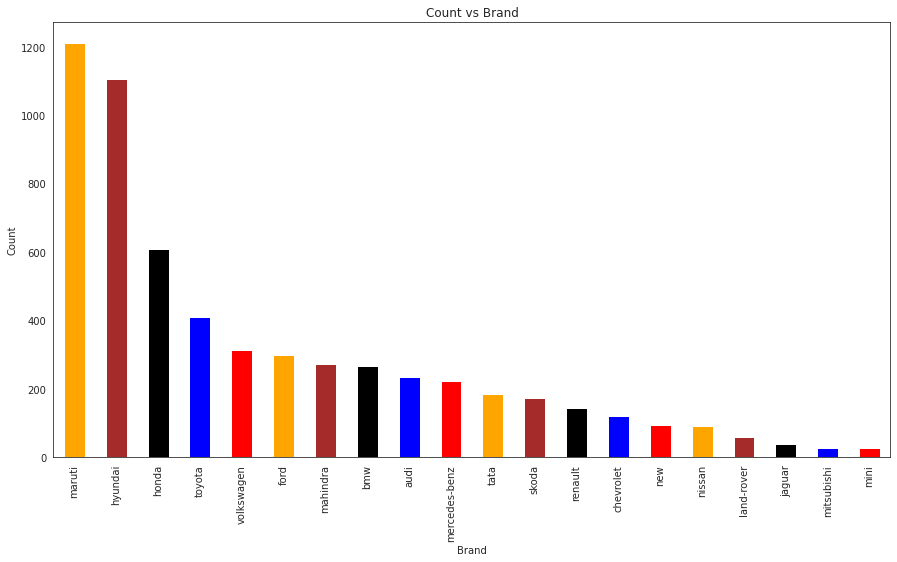

In [27]:
# Distribution of car sales by Brand for highest 20
plt.figure(figsize=(15, 8))
df_new['Brand'].value_counts().nlargest(20).plot(x='Brand', kind='bar', color=['Orange','Brown','Black','Blue','Red'])
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Count vs Brand')
plt.show()

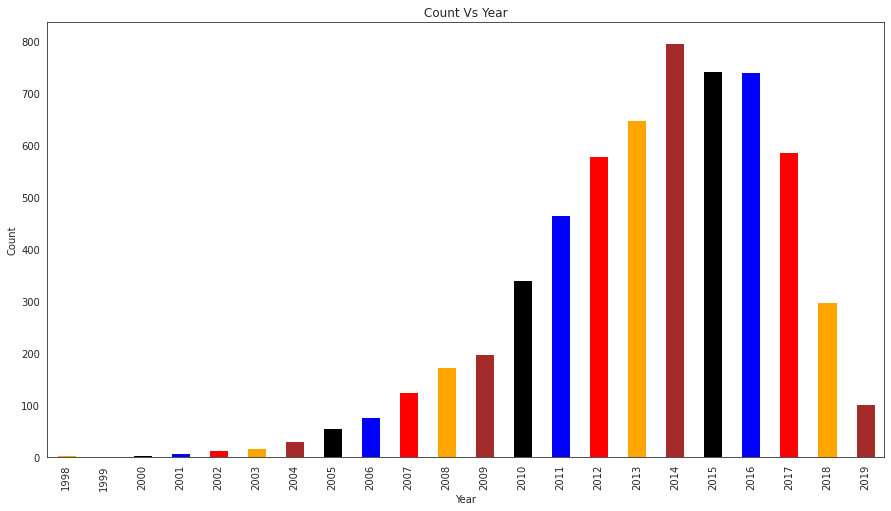

In [28]:
# Distribution of car sales by Model Year
plt.figure(figsize=(15, 8))
df_new['Year'].value_counts().sort_index().plot(x='Year', kind='bar', color=['Orange','Brown','Black','Blue','Red'])
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count Vs Year')
plt.show()

There were a lot more sales of cars with Model years between 2011 and 2017. 

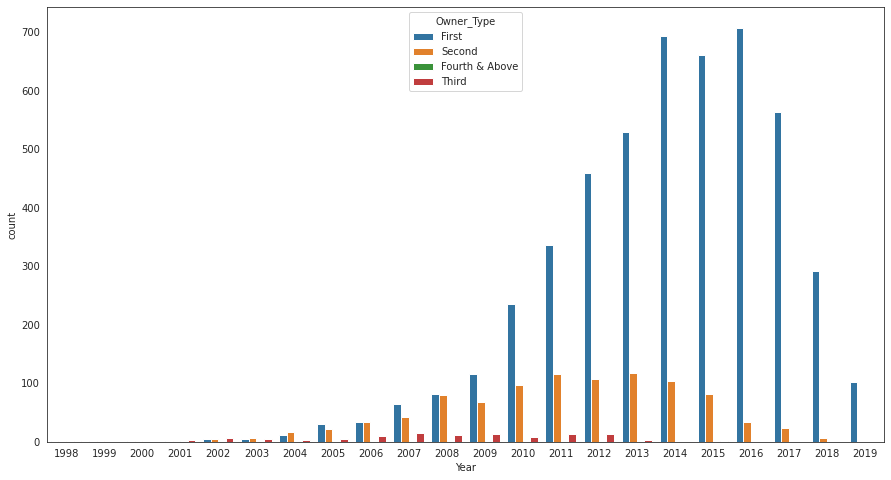

In [29]:
plt.figure(figsize=(15, 8))
sns.countplot(x="Year", hue="Owner_Type", data=df_new)
plt.show()

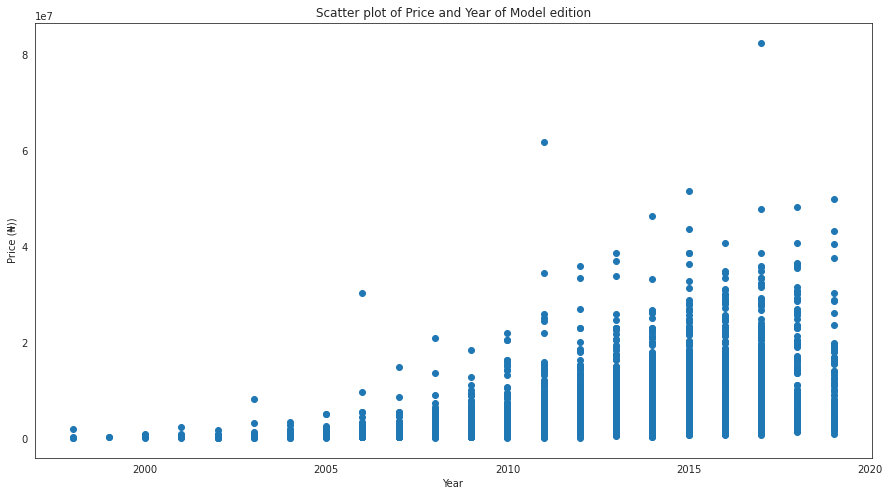

In [30]:
plt.figure(figsize=(15, 8))
plt.scatter(df_new.Year, df_new.Price)
plt.xlabel("Year")
plt.ylabel("Price (₦))")
plt.title("Scatter plot of Price and Year of Model edition")
plt.show()

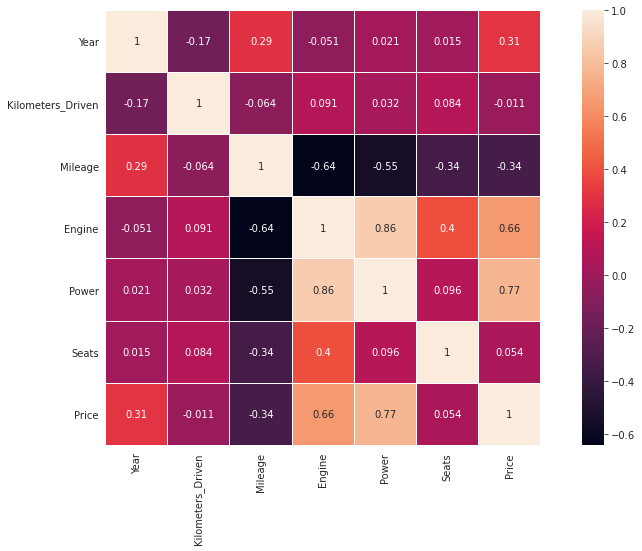

In [31]:
plt.figure(figsize=(15, 8))
sns.heatmap(df_new.corr(), linewidths=.1, vmax=1.0, square=True, annot=True)
plt.show()

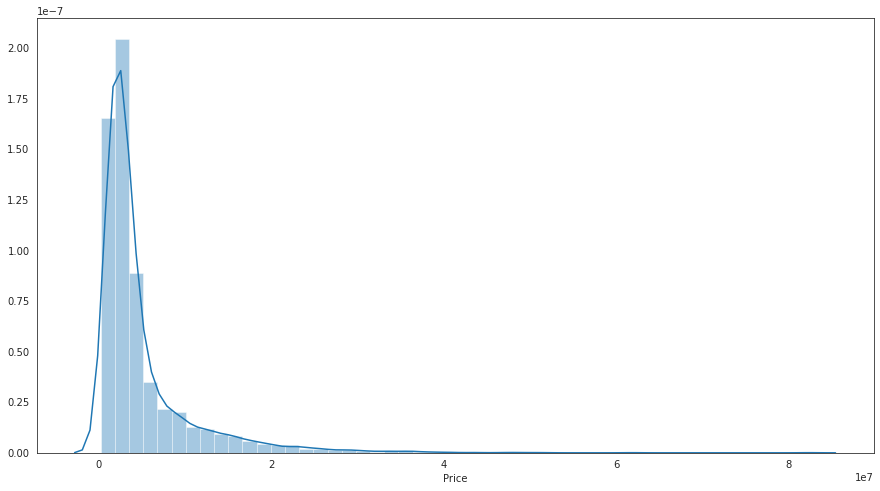

In [32]:
# Price distribution
plt.figure(figsize=(15, 8))
sns.distplot(df_new['Price'])
plt.show()

In [33]:
# Check skewness of target variable `Price`
df_new.Price.skew()

3.3352319876668415

# Data Modelling

In [34]:
# drop car with name 'new'
df_new2 = df_new[df_new.Name != "new - -"]
#  drop car name, variant column
df_new2 = df_new2.drop(['Name', 'Variant'], axis=1)
df_new2.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand,Model
0,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,901250.0,maruti,wagon-r
1,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,6437500.0,hyundai,creta
2,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,2317500.0,honda,jazz
3,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,3090000.0,maruti,ertiga
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,9136100.0,audi,a4


## Convert data to CSV for saving in database

In [35]:
# create a copy of cleaned data
df_save = df_new2.copy()
df_save['id'] = np.nan
df_save.to_csv('../data/clean_data.csv', 
        header=['location', 'year', 'km_driven', 'fuel_type', 'transmission', 'owner_type',
                'mileage', 'engine', 'power', 'seats', 'price', 'brand', 'model', 'id'],
        index=False)

## One-hot Encoding

In [36]:
# Separate features and target variables
X = df_new2.drop('Price', axis=1)
# Considering our target variable is quite skewed,
# lets do some log transformation
y = np.log1p(df_new2['Price'])
X = pd.get_dummies(data=X, columns=['Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Seats', 'Brand', 'Model'])

## Model Training

In [37]:
# split data into training and validation datasets 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=101)

## Linear Regression

In [39]:
lr = LinearRegression()

In [40]:
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
predictions = lr.predict(X_valid)

In [42]:
print('MAE:', metrics.mean_absolute_error(y_valid, predictions))
print('MSE:', metrics.mean_squared_error(y_valid, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, predictions)))

MAE: 0.13408098949916386
MSE: 0.033667463101077766
RMSE: 0.1834869562150884


In [43]:
metrics.explained_variance_score(y_valid, predictions)

0.9563858415221261

In [44]:
compare_df = pd.DataFrame({'validation': y_valid, 'prediction': predictions}); compare_df

,validation,prediction
4409,14.330578,14.247381
812,15.032913,14.903733
3103,13.711539,14.111874
2167,14.633527,14.685631
5664,13.819753,13.620965
...,...,...
5607,15.594269,15.434284
821,15.783811,15.920475
302,13.893860,13.934242
4690,15.291989,15.149474


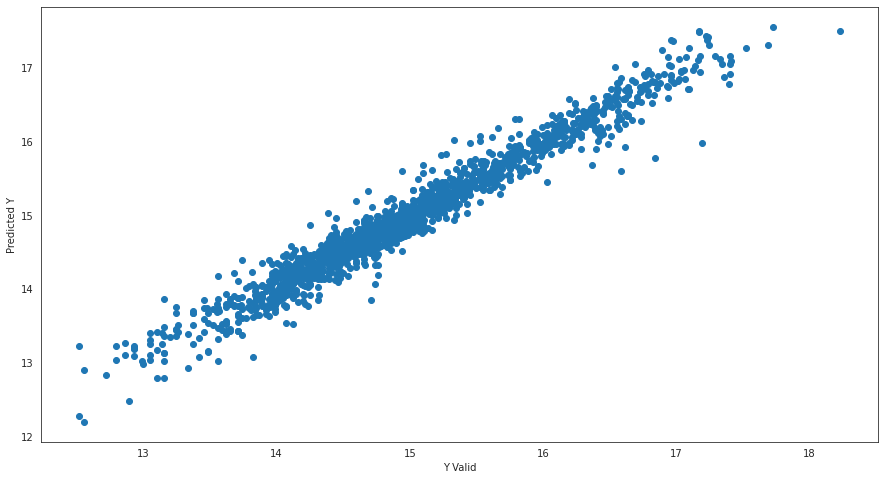

In [45]:
# Create a scatterplot of the real test values versus the predicted values.
plt.figure(figsize=(15, 8))
plt.scatter(y_valid, predictions)
plt.xlabel('Y Valid')
plt.ylabel('Predicted Y')
plt.show()

We seem to have a fairly good fit with our Linear regression model, let's plot the residual to makesure it's normally distributed

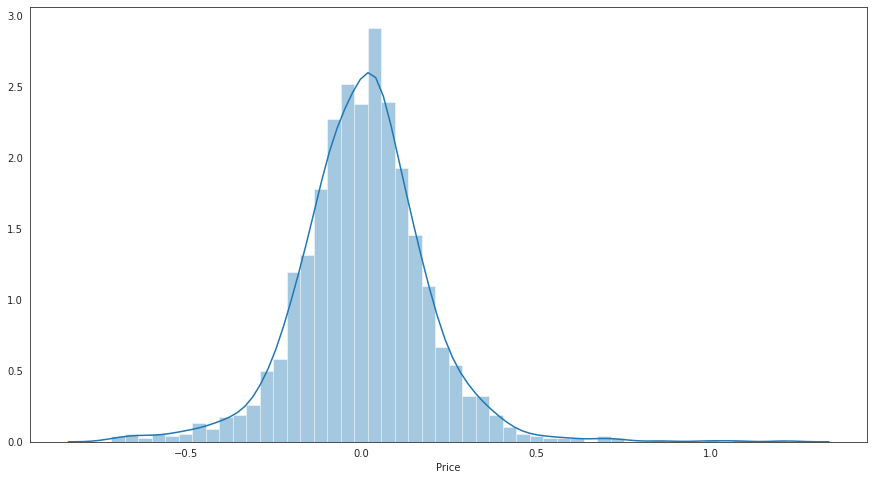

In [46]:
plt.figure(figsize=(15, 8))
sns.distplot((y_valid - predictions),bins=50)
plt.show()

## Save Model

In [48]:
df_new['Location']

<bound method Series.unique of 0           Mumbai
1             Pune
2          Chennai
3          Chennai
4       Coimbatore
           ...    
6014         Delhi
6015        Jaipur
6016        Jaipur
6017       Kolkata
6018     Hyderabad
Name: Location, Length: 6019, dtype: object>

In [47]:
today = date.today()
day = today.day
month = today.month
year = today.year

joblib.dump(lr, f'../models/{year}_{month:02d}_{day:02d}.pkl')

['../models/2020_05_10.pkl']